In [61]:
import os
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
import matplotlib.pyplot as plt

In [62]:
# Dataset
dataset_path = os.path.join(os.getcwd(), 'dataset')
raw_dataset = os.path.join(dataset_path, 'spam_message.csv')
preprocessed_dataset = os.path.join(dataset_path, 'preprocessed_spam_message.csv')
embedded_dataset = os.path.join(dataset_path, 'embedded_spam_message.pkl')
test_embedded_dataset = os.path.join(dataset_path, 'embedded_spam_message_test.pkl')

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [64]:
df = pd.read_pickle(embedded_dataset)
df.head()

,text,text_list,embed_vector,embed_vector_padded,class
index,,,,,
0,bear pic nick tom pete ... dick fact type atte...,"[bear, pic, nick, tom, pete, ..., dick, fact, ...","[[-0.1318, -0.0213, -0.0437, -0.0105, -0.0594,...","[[-0.1318, -0.0213, -0.0437, -0.0105, -0.0594,...",1
1,also didnt get na hi hi hi hi hi,"[also, didnt, get, na, hi, hi, hi, hi, hi]","[[-0.0764, 0.0451, -0.0883, 0.0223, -0.2671, 0...","[[-0.0764, 0.0451, -0.0883, 0.0223, -0.2671, 0...",0
2,dear -/ mood cant drive brother drive,"[dear, -/, mood, cant, drive, brother, drive]","[[0.0358, -0.0997, -0.0147, -0.0107, 0.033, 0....","[[0.0358, -0.0997, -0.0147, -0.0107, 0.033, 0....",0
3,december mobile 11mths+ entitled update latest...,"[december, mobile, 11mths+, entitled, update, ...","[[0.1012, 0.0564, -0.0415, -0.1268, 0.0861, 0....","[[0.1012, 0.0564, -0.0415, -0.1268, 0.0861, 0....",1
4,\hello u.call wen u finish wrk.i fancy meetin ...,"[\hello, u.call, wen, u, finish, wrk.i, fancy,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


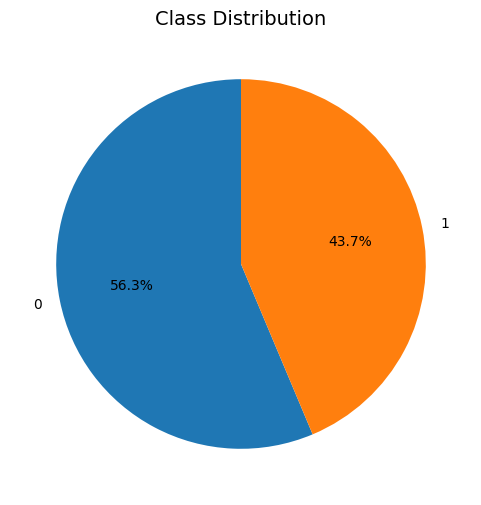

In [65]:


# Count the number of samples per class
class_counts = df['class'].value_counts()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    class_counts, 
    labels=class_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    # shadow=True
)

# Add title
plt.title("Class Distribution", fontsize=14)
plt.show()

In [66]:
df_test = pd.read_pickle(test_embedded_dataset)
df_test.head()

,embed_vector_padded,class
index,,
937,"[[0.0168, 0.0959, -0.1346, -0.0783, -0.0284, 0...",0
3813,"[[-0.0288, 0.1036, -0.0177, 0.0937, 0.1637, 0....",0
3047,"[[0.1798, -0.1175, -0.2733, -0.1253, -0.1611, ...",0
5056,"[[-0.1758, -0.0359, -0.1057, -0.0703, -0.035, ...",0
5460,"[[0.1012, 0.0564, -0.0415, -0.1268, 0.0861, 0....",1


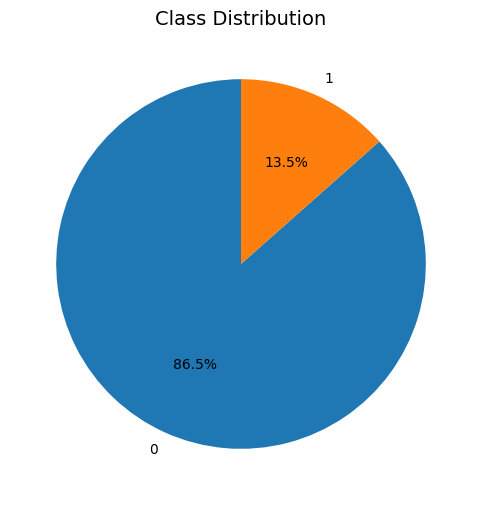

In [67]:
# Count the number of samples per class
class_counts = df_test['class'].value_counts()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    class_counts, 
    labels=class_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    # shadow=True
)

# Add title
plt.title("Class Distribution", fontsize=14)
plt.show()

# Utils

In [68]:
def confusion_counts(y_true, y_pred):
    """
    Computes raw TP, FP, TN, FN for binary classification
    """
    y_true = y_true.cpu()
    y_pred = y_pred.cpu()

    TP = ((y_pred == 1) & (y_true == 1)).sum().item()
    TN = ((y_pred == 0) & (y_true == 0)).sum().item()
    FP = ((y_pred == 1) & (y_true == 0)).sum().item()
    FN = ((y_pred == 0) & (y_true == 1)).sum().item()

    return TP, FP, TN, FN

In [69]:
# model evaluation
def test_model(model, test_loader, criterion, device):
    """
    Evaluates the model on the test dataset.

    Parameters:
    - model (nn.Module): The trained model to evaluate.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - criterion (nn.Module): The loss function (e.g., nn.CrossEntropyLoss).
    - device (torch.device): The device to run on (e.g., 'cuda' or 'cpu').
    """
    
    # Set the model to evaluation mode (e.g., turns off dropout)
    model.eval()
    
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    all_preds = []
    all_labels = []

    # Disable gradient calculations
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            # Move data to the specified device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            
            # Calculate the loss
            loss = criterion(outputs, y_batch)
            
            # Accumulate the loss
            test_loss += loss.item() * X_batch.size(0)
            
            # Get the predictions
            _, preds = torch.max(outputs, 1)
            
            # Accumulate correct predictions and total count
            test_correct += (preds == y_batch).sum().item()
            test_total += y_batch.size(0)
            
            # Store all predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Calculate final metrics
    avg_test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total
    
    # --- Calculate TP, FP, TN, FN for binary classification ---
    # Assumes class 1 is the "positive" class
    TP, FP, TN, FN = 0, 0, 0, 0
    
    for i in range(len(all_preds)):
        pred = all_preds[i]
        label = all_labels[i]
        
        if pred == 1 and label == 1:
            TP += 1
        elif pred == 1 and label == 0:
            FP += 1
        elif pred == 0 and label == 0:
            TN += 1
        elif pred == 0 and label == 1:
            FN += 1

    # Calculate Precision, Recall, and F1-score
    # Add a small epsilon (1e-6) to avoid division by zero
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

    # Print the results
    print("\n--- Test Results ---")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_correct}/{test_total})")
    print("---")
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Negatives (FN): {FN}")
    print("---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    print("--------------------\n")

    return avg_test_loss, test_accuracy, precision, recall, f1_score


# Dataset Formatting

In [70]:
class EmbeddedDataset(Dataset):
    def __init__(self, dataframe, feature_col='embed_vector_padded', label_col='class', transform=None):
        self.df = dataframe
        self.feature_col = feature_col
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        X = self.df.iloc[idx][self.feature_col]
        y = self.df.iloc[idx][self.label_col]

        if not torch.is_tensor(X):
            X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)

        if self.transform:
            X = self.transform(X)

        return X, y
    
test_dataset = EmbeddedDataset(df)
test_dataset[:10]

(tensor([[[-0.1318, -0.0213, -0.0437,  ...,  0.0911,  0.1070, -0.3065],
          [-0.0712, -0.0808, -0.0530,  ...,  0.0595, -0.0219, -0.0339],
          [-0.0623, -0.0200, -0.0133,  ...,  0.0865, -0.1589, -0.1660],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.0764,  0.0451, -0.0883,  ...,  0.1588,  0.0052, -0.0104],
          [-0.0405, -0.0423,  0.0548,  ...,  0.2621, -0.1112,  0.0532],
          [-0.1220,  0.0626,  0.0448,  ...,  0.2599,  0.1448,  0.0499],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0358, -0.0997, -0.0147,  ...,  0.1303,  0.0927, -0.2438],
          [ 0.0000,  0.0000,

In [71]:
dataset = EmbeddedDataset(df)
x, y = dataset[0]

print(x, y)
print(x.shape, y.shape)

print('===')

test_dataset = EmbeddedDataset(df_test)
x, y = test_dataset[0]

print(x, y)
print(x.shape, y.shape)

tensor([[-0.1318, -0.0213, -0.0437,  ...,  0.0911,  0.1070, -0.3065],
        [-0.0712, -0.0808, -0.0530,  ...,  0.0595, -0.0219, -0.0339],
        [-0.0623, -0.0200, -0.0133,  ...,  0.0865, -0.1589, -0.1660],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]) tensor(1)
torch.Size([100, 300]) torch.Size([])
===
tensor([[ 0.0168,  0.0959, -0.1346,  ..., -0.0861, -0.1484,  0.0030],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1006, -0.1081,  0.0860,  ..., -0.2936, -0.1335,  0.1077],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]) tensor(0)
torch.Size([100, 300]) torch.Size([])


In [72]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# GRU

In [73]:
from model.gru_architecture import GRUClassifier

In [93]:
# GRU Test
hidden_size = 128
input_size = 300
num_layers = 2
num_classes = 2

model_gru = GRUClassifier(input_size=input_size, 
                      hidden_size=hidden_size, 
                      num_layers=num_layers, 
                      num_classes=num_classes)

model_gru.to(device)
test_data = torch.tensor(df['embed_vector_padded'][0], dtype=torch.float32).to('cuda')
test_data = test_data.unsqueeze(0)
print(test_data.shape)

model_gru(test_data)

torch.Size([1, 100, 300])


tensor([[ 0.0197, -0.0634]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [94]:
# Hyper Parameter
learning_rate = 1e-2
weight_decay = 5e-3
momentum = 0.9
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model_gru.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

In [95]:
# Train
num_epochs = 10

TP_list, FP_list, TN_list, FN_list = [], [], [], []

for epoch in tqdm(range(num_epochs)):
    # ---- TRAIN ----
    model_gru.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model_gru(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_acc = train_correct / train_total
    train_loss /= train_total

    # ---- VALIDATION ----
    model_gru.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    epoch_TP, epoch_FP, epoch_TN, epoch_FN = 0, 0, 0, 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_gru(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

            tp, fp, tn, fn = confusion_counts(y_batch, preds)
            
            epoch_TP += tp
            epoch_FP += fp
            epoch_TN += tn
            epoch_FN += fn
            
    val_acc = val_correct / val_total
    val_loss /= val_total

    TP_list.append(epoch_TP)
    FP_list.append(epoch_FP)
    TN_list.append(epoch_TN)
    FN_list.append(epoch_FN)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
          f"Val TP: {epoch_TP}, FP: {epoch_FP}") # Example print

print("TP_list", TP_list)
print("FP_list", FP_list)
print("TN_list", TN_list)
print("FN_list", FN_list)

 10%|█         | 1/10 [00:36<05:31, 36.83s/it]

Epoch [1/10] Train Loss: 0.4481, Acc: 0.7877 | Val Loss: 0.1731, Acc: 0.9369 | Val TP: 321, FP: 31


 20%|██        | 2/10 [01:15<05:04, 38.09s/it]

Epoch [2/10] Train Loss: 0.1451, Acc: 0.9482 | Val Loss: 0.1346, Acc: 0.9498 | Val TP: 324, FP: 23


 30%|███       | 3/10 [01:55<04:30, 38.60s/it]

Epoch [3/10] Train Loss: 0.1372, Acc: 0.9480 | Val Loss: 0.1190, Acc: 0.9498 | Val TP: 319, FP: 18


 40%|████      | 4/10 [02:32<03:49, 38.28s/it]

Epoch [4/10] Train Loss: 0.1166, Acc: 0.9571 | Val Loss: 0.1222, Acc: 0.9533 | Val TP: 313, FP: 9


 50%|█████     | 5/10 [03:11<03:13, 38.61s/it]

Epoch [5/10] Train Loss: 0.1115, Acc: 0.9602 | Val Loss: 0.1288, Acc: 0.9521 | Val TP: 307, FP: 4


 60%|██████    | 6/10 [03:50<02:33, 38.45s/it]

Epoch [6/10] Train Loss: 0.0997, Acc: 0.9648 | Val Loss: 0.0919, Acc: 0.9603 | Val TP: 325, FP: 15


 70%|███████   | 7/10 [04:28<01:55, 38.33s/it]

Epoch [7/10] Train Loss: 0.1055, Acc: 0.9617 | Val Loss: 0.0920, Acc: 0.9614 | Val TP: 327, FP: 16


 80%|████████  | 8/10 [05:06<01:16, 38.18s/it]

Epoch [8/10] Train Loss: 0.1004, Acc: 0.9644 | Val Loss: 0.1000, Acc: 0.9614 | Val TP: 316, FP: 5


 90%|█████████ | 9/10 [05:43<00:38, 38.09s/it]

Epoch [9/10] Train Loss: 0.1091, Acc: 0.9587 | Val Loss: 0.1170, Acc: 0.9544 | Val TP: 333, FP: 28


100%|██████████| 10/10 [06:21<00:00, 38.12s/it]

Epoch [10/10] Train Loss: 0.0909, Acc: 0.9670 | Val Loss: 0.1076, Acc: 0.9603 | Val TP: 313, FP: 3
TP_list [321, 324, 319, 313, 307, 325, 327, 316, 333, 313]
FP_list [31, 23, 18, 9, 4, 15, 16, 5, 28, 3]
TN_list [481, 489, 494, 503, 508, 497, 496, 507, 484, 509]
FN_list [23, 20, 25, 31, 37, 19, 17, 28, 11, 31]


## Evaluation GRU

In [112]:
avg_test_loss, test_accuracy, precision, recall, f1_score=test_model(model_gru, test_loader, criterion, device)
(avg_test_loss, test_accuracy, precision, recall, f1_score)


--- Test Results ---
Test Loss: 0.0319
Test Accuracy: 0.9928 (553/557)
---
True Positives (TP): 73
False Positives (FP): 2
True Negatives (TN): 480
False Negatives (FN): 2
---
Precision: 0.9733
Recall: 0.9733
F1-Score: 0.9733
--------------------



(0.03190209169803552,
 0.992818671454219,
 0.9733333203555558,
 0.9733333203555558,
 0.9733328203558127)

In [97]:
model_gru

GRUClassifier(
  (gru): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

# LSTM

In [98]:
from model.lstm_arcitecture import LSTMClassifier

In [106]:
# LSTM Test
hidden_size = 128
input_size = 300
num_layers = 2
num_classes = 2

model_lstm = LSTMClassifier(input_size=input_size, 
                      hidden_size=hidden_size, 
                      num_layers=num_layers, 
                      num_classes=num_classes)

model_lstm.to(torch.device('cuda'))
test_data = torch.tensor(df['embed_vector_padded'][:4], dtype=torch.float32).to('cuda')
# test_data = test_data.unsqueeze(0)
print(test_data.shape)

model_lstm(test_data)

torch.Size([4, 100, 300])


tensor([[-0.0078,  0.0268],
        [-0.0020,  0.0171],
        [-0.0181,  0.0327],
        [-0.0017,  0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [107]:
# Hyper Parameter
num_classes = 2
learning_rate = 1e-2
weight_decay = 5e-3
momentum = 0.9

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model_lstm.parameters(), lr=learning_rate, weight_decay=5e-3, momentum=0.9)

In [108]:
# Train
num_epochs = 10
h0, c0 = None, None

TP_list, FP_list, TN_list, FN_list = [], [], [], []

for epoch in tqdm(range(num_epochs)):
    # ---- TRAIN ----
    model_lstm.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model_lstm(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_acc = train_correct / train_total
    train_loss /= train_total

    # ---- VALIDATION ----
    model_lstm.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    epoch_TP, epoch_FP, epoch_TN, epoch_FN = 0, 0, 0, 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_lstm(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
            
            tp, fp, tn, fn = confusion_counts(y_batch, preds)
            
            epoch_TP += tp
            epoch_FP += fp
            epoch_TN += tn
            epoch_FN += fn
            
    val_acc = val_correct / val_total
    val_loss /= val_total

    TP_list.append(epoch_TP)
    FP_list.append(epoch_FP)
    TN_list.append(epoch_TN)
    FN_list.append(epoch_FN)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

print("TP_list", TP_list)
print("FP_list", FP_list)
print("TN_list", TN_list)
print("FN_list", FN_list)

 10%|█         | 1/10 [00:39<05:52, 39.14s/it]

Epoch [1/10] Train Loss: 0.6816, Acc: 0.5592 | Val Loss: 0.6629, Acc: 0.5981


 20%|██        | 2/10 [01:18<05:12, 39.09s/it]

Epoch [2/10] Train Loss: 0.5879, Acc: 0.7116 | Val Loss: 0.2994, Acc: 0.8879


 30%|███       | 3/10 [01:57<04:34, 39.20s/it]

Epoch [3/10] Train Loss: 0.2009, Acc: 0.9271 | Val Loss: 0.2068, Acc: 0.9241


 40%|████      | 4/10 [02:36<03:54, 39.06s/it]

Epoch [4/10] Train Loss: 0.1473, Acc: 0.9482 | Val Loss: 0.1390, Acc: 0.9428


 50%|█████     | 5/10 [03:15<03:15, 39.19s/it]

Epoch [5/10] Train Loss: 0.1405, Acc: 0.9512 | Val Loss: 0.1854, Acc: 0.9264


 60%|██████    | 6/10 [03:54<02:36, 39.15s/it]

Epoch [6/10] Train Loss: 0.1249, Acc: 0.9588 | Val Loss: 0.1178, Acc: 0.9579


 70%|███████   | 7/10 [04:33<01:57, 39.11s/it]

Epoch [7/10] Train Loss: 0.1180, Acc: 0.9592 | Val Loss: 0.1165, Acc: 0.9568


 80%|████████  | 8/10 [05:12<01:17, 38.91s/it]

Epoch [8/10] Train Loss: 0.1192, Acc: 0.9592 | Val Loss: 0.1601, Acc: 0.9369


 90%|█████████ | 9/10 [05:51<00:38, 38.87s/it]

Epoch [9/10] Train Loss: 0.1161, Acc: 0.9600 | Val Loss: 0.1370, Acc: 0.9498


100%|██████████| 10/10 [06:29<00:00, 38.96s/it]

Epoch [10/10] Train Loss: 0.1120, Acc: 0.9602 | Val Loss: 0.1150, Acc: 0.9579
TP_list [0, 292, 328, 311, 331, 320, 316, 332, 330, 327]
FP_list [0, 44, 49, 16, 50, 12, 9, 42, 29, 19]
TN_list [512, 468, 463, 496, 462, 500, 503, 470, 483, 493]
FN_list [344, 52, 16, 33, 13, 24, 28, 12, 14, 17]


In [113]:
avg_test_loss, test_accuracy, precision, recall, f1_score=test_model(model_lstm, test_loader, criterion, device)
(avg_test_loss, test_accuracy, precision, recall, f1_score)


--- Test Results ---
Test Loss: 0.0794
Test Accuracy: 0.9785 (545/557)
---
True Positives (TP): 74
False Positives (FP): 11
True Negatives (TN): 471
False Negatives (FN): 1
---
Precision: 0.8706
Recall: 0.9867
F1-Score: 0.9250
--------------------



(0.07941561685858338,
 0.9784560143626571,
 0.8705882250519033,
 0.9866666535111113,
 0.9249994903908934)

In [111]:
model_lstm

LSTMClassifier(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)